![Py4Eng](img/logo.png)

# Python-Matlab interface
## Yoav Ram

In this session we will call MATLAB (or Octave) functions and code from Python.

# Setup

Make sure you have MATLAB installed (on Linux or Mac you can try calling `which matlab` in the terminal). 

If you don't have MATLAB you can either install it or install _Octave_ for free (see bottom of session for instructions on installing and using Octave in this session).

To talk to MATLAB from Python we will use the [`pymatbridge`](https://arokem.github.io/python-matlab-bridge/) package.

Install `pymatbridge` and dependencies:

```
conda install pyzmq numpy
pip install pymatbridge
```

on Mac you might also need to `brew install zeromq`.

Let's make sure everything works by importing the bridge and having it start off a MATLAB server:

In [4]:
import numpy as np
from pymatbridge import Octave, Matlab

In [64]:
# change between Matlab and Octave acording to what you use.
# you can also provide path to matlab/octave binary as an argument
mat = Octave()

If the following fails then you probably had issues installing MATLAB/Octave or `pymatbridge`. Consult the above for MATLAB, the bottom of the session for Octave, or [pymatbridge issues](https://github.com/arokem/python-matlab-bridge/issues) for help.

In [65]:
mat.start()

Starting Octave on ZMQ socket ipc:///tmp/pymatbridge-42d7e807-42bb-41d4-b6d0-9cb0e7053ddc
Send 'exit' command to kill the server
.Octave started and connected!


# Hello MATLAB

Let's run some simple MATLAB code to make sure it works. We'll create a variable called `a` and set it to `1`.

In [76]:
result = mat.run_code('a=1;')
print('success:', result['success'])

success: True


The `result` variable contains the answer from the MATLAB server, which contains both the `success` of the operation, the `stdout` which is useful if it failed or if we expected console output, and some more information.

In [77]:
result

{'content': {'datadir': '/var/folders/qn/3hj7mcx56k19b_09n6dymw8h0000gn/T/MatlabData/',
  'figures': [],
  'stdout': ''},
 'result': [],
 'stack': [],
 'success': True}

Now let's get the variable value:

In [78]:
a = mat.get_variable('a')
print(a, type(a))

1 <class 'int'>


Note that the value was automarically converted for us to `int`. This would happen even if we were to explicitly set it to a `float` because of how numbers are interpreted differently in MATLAB and Python.

In [81]:
a = mat.set_variable('b', 1.0)
type(mat.get_variable('b'))

int

We can now use MATLAB operations and functions to process Python data - including NumPy arrays:

In [89]:
x = np.arange(100).reshape(10, 10)
mat.set_variable('x', x)
mat.run_code('y=x*2;')
y = mat.get_variable('y')
y[:3, :3]

array([[  0.,   2.,   4.],
       [ 20.,  22.,  24.],
       [ 40.,  42.,  44.]])

## Exercise

Use MATLAB to calculate the [LU factorization](https://www.mathworks.com/help/matlab/ref/lu.html) of the following matrix `A`. Then use `np.allclose` to verify the result.

In [91]:
A = np.random.random((5, 5))
A

array([[ 0.08419732,  0.71108106,  0.90856964,  0.09412131,  0.47851473],
       [ 0.0816439 ,  0.07997498,  0.53516609,  0.30457407,  0.68684703],
       [ 0.97971642,  0.0523722 ,  0.32030873,  0.54089573,  0.64442956],
       [ 0.89741285,  0.76780268,  0.48746324,  0.11426007,  0.97184533],
       [ 0.58274074,  0.21716351,  0.06096504,  0.4888153 ,  0.07294107]])

True

# Calling MATLAB user defined functions

Here's a simple MATLAB function that calculates the first `n` Fibonacci numbers.

## Fibonacci

In [82]:
%%file fib.m
function f = fibonacci(args)
    n = args.n;
    f = zeros(n, 1);
    f(1) = 1;
    f(2) = 1;
    for k = 3:n
        f(k) = f(k-1) + f(k-2);
    end
end

Overwriting fib.m


We can wrap it with a Python function:

In [87]:
def matfib(n):
    result = mat.run_func('fib.m', dict(n=n))
    assert result['success']
    return result['result'].squeeze() # MATLAB returns 2D
x = matfib(5)
print(x)
x.dtype

[ 1.  1.  2.  3.  5.]


dtype('float64')

Note that the return value was automatically converted to NumPy array with data type `float64` and not a to a Python list of integers.

Let's compete the MATLAB version with a NumPy version:

In [84]:
def fib(n):
    f = np.zeros(n)
    f[0] = 1
    f[1] = 1
    for k in range(2, n):
        f[k] = f[k-1] + f[k-2]
    return f
fib(5)

array([ 1.,  1.,  2.,  3.,  5.])

In [52]:
%timeit fib(50)
%timeit matfib(50)

100000 loops, best of 3: 16.9 µs per loop
10 loops, best of 3: 135 ms per loop


The NumPy version is faster, probably because there is no inter-process communication and data conversions involved.

## Exercise 2

Write a MATLAB function that given an input 1D array returns the cumulative sum of the array. For example, for `[1, 2, 3]` it should return `[1, 3, 6]`. Then wrap it with a Python function. Make sure the result satisfies the assertion below.

In [108]:
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
assert np.allclose(
    cumsum(x), 
    np.array([  1.,   3.,   6.,  10.,  15.,  21.,  28.,  36.,  45.,  55.])
)

# Notebook magic

`pymatbridge` has a convinient notebook magic that allows us to run MATLAB code from the notebook without the overhead that we had above.

In [1]:
# MATLAB
# %load_ext pymatbridge

# Octave
ip = get_ipython()
import pymatbridge
pymatbridge.load_ipython_extension(ip, matlab='octave')

Starting Octave on ZMQ socket ipc:///tmp/pymatbridge-0d2ac3da-e1e4-4ced-a958-d1fe325a1ea0
Send 'exit' command to kill the server
.Octave started and connected!


Check out the `%%matlab` magic help: we can pass input and output between Python and MATLAB, and control other options.

In [2]:
%%matlab?

In [6]:
A = np.random.random((2, 2))
print(A)

[[ 0.82974011  0.734994  ]
 [ 0.08323233  0.11977421]]


In [7]:
%%matlab -i A -o B
B = A.*2;

In [8]:
print(B)

[[ 1.65948022  1.46998799]
 [ 0.16646467  0.23954842]]


We can write MATLAB functions using the magic mand evaluate them using additional magic.

In [9]:
%%matlab
function [ result ] = fibonacci(n)
    if n==0||n==1
        result = n;
    else
        result = fibonacci(n-2) + fibonacci(n-1);
    end
end

In [10]:
%%matlab -o f
f = fibonacci(10);

In [11]:
f

55

## Exercise 3

Plot x vs. y with MATLAB - you need to use `-g` in the magic command call. Don't be lazy: add axis labels!

In [27]:
from scipy.special import erf
x = np.linspace(0, np.pi)
y = erf(x)

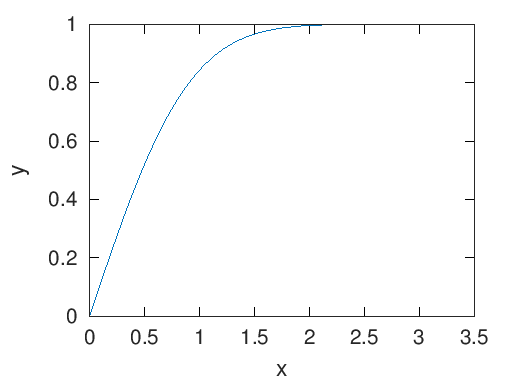

# Using Octave

To setup minimal (no GUI) Octave on Mac, install _XCode_ from _App Store_, then install [Homebrew](https://brew.sh/) and use it to install Octave (see [formula](https://github.com/Homebrew/homebrew-science/blob/master/octave.rb):
```
brew tap homebrew/science
brew update
brew install zeromq
brew install octave --without-gui --with-java
```

Clone [pymatbridge](https://github.com/arokem/python-matlab-bridge) repo, `cd python-matlab-bridge/pymatbridge/messenger`, edit the file `mexmaci64/local.cfg` to have these lines (replacing `USERNAME` with your username):

```
ZMQ_INC=/Users/USERNAME/homebrew/include
ZMQ_LIB=/Users/USERNAME/homebrew/lib
```

then run `python make.py octave`. If it worked, cd back to the repo folder (`cd ../..`) and run `python setup.py install`.

The replace in the above Python code `Matlab` with `Octave`.

# Solutions

## Exercise 1

In [94]:
mat.set_variable('A', A)
mat.run_code('[L, U] = lu(A);')
L = mat.get_variable('L')
U = mat.get_variable('U')
np.allclose(L @ U , A)

True

## Exercise 2

In [ ]:
%%file cumsum.m
function output = cumsum(args)
    input = args.input;
    output = zeros(size(input));
    output(1) = input(1);
    for k = 2:size(input, 2)
        output(k) = output(k-1) + input(k);
    end
end

In [ ]:
def cumsum(x):
    result = mat.run_func('cumsum.m', dict(input=x))
    assert result['success']
    return result['result'].squeeze() # MATLAB returns 2D

## Exercise 3

In [ ]:
%%matlab -g -i x -i y
plot(x, y)
xlabel('x')
ylabel('y')

## Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Python for Engineers_](https://github.com/yoavram/Py4Eng) course.

The notebook was written using [Python](http://python.org/) 3.6.1.
Dependencies listed in [environment.yml](../environment.yml), full versions in [environment_full.yml](../environment_full.yml).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)